In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
import os
from model_toy import get_toy_ResNet

# Set GPU visibility to first device only
physical_devices = tf.config.get_visible_devices('GPU')
tf.config.set_visible_devices(physical_devices[:1], 'GPU')
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Benchmark

In [2]:
def timeit(func, *args, max_iterations=200, **kwargs):
    # First call not timed
#     func(*args, **kwargs)
    # Time iterations
    times = []
    for counter in range(max_iterations):
        t1 = perf_counter()
        func(*args, **kwargs)
        times.append(perf_counter() - t1)
        
    print("%d iterations. Time/iter: %.4f sec" % (counter +1, np.mean(times)))
    plt.stem(times, use_line_collection=True)

In [3]:
batch_size = 32
loss_fn    = tf.keras.losses.sparse_categorical_crossentropy
optimizer  = tf.keras.optimizers.RMSprop()
acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [4]:
(x_train_full, y_train_full), _ = tf.keras.datasets.cifar10.load_data()
x_batch = tf.constant(x_train_full[:batch_size]/255., dtype=tf.float32)
y_batch = tf.constant(y_train_full[:batch_size], dtype=tf.float32)
print("x_batch:", x_batch.shape)
print("y_batch:", y_batch.shape)

x_batch: (32, 32, 32, 3)
y_batch: (32, 1)


## Built-in method

200 iterations. Time/iter: 0.0544 sec


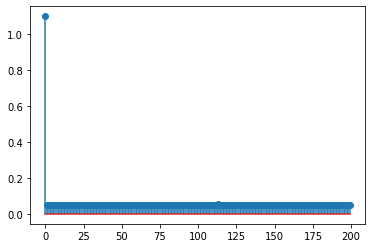

In [5]:
model = get_toy_ResNet()

model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

timeit(model.train_step, (x_batch, y_batch))

200 iterations. Time/iter: 0.0182 sec


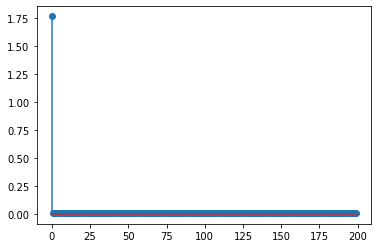

In [6]:
model = get_toy_ResNet()
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])
timeit(model.train_on_batch, x_batch, y_batch)

## Custom train step

In [7]:
from sklearn.metrics import accuracy_score

def train_step(x_batch, y_batch, model, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        # Forward
        y_pred   = model(x_batch, training=True)
        out_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        tot_loss = tf.add_n([out_loss] + model.losses) ## In case there are extra losses from the layers (l2 normalisation, etc..)
    # Backward    
    gradients = tape.gradient(tot_loss, model.trainable_variables)
    # Update
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return y_pred, tot_loss

def evaluate(model, x, y):
    y_pred = np.argmax(model(x), axis=1)
    print("Accuracy: %.3f"% accuracy_score(y, y_pred))

200 iterations. Time/iter: 0.0468 sec


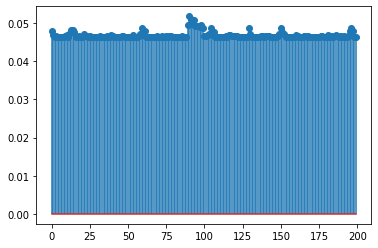

In [8]:
model = get_toy_ResNet()

timeit(train_step, x_batch, y_batch, model, loss_fn, optimizer)

200 iterations. Time/iter: 0.0040 sec


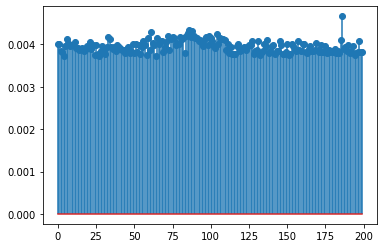

In [9]:
model = get_toy_ResNet()
tf_train_step = tf.function(train_step)

timeit(tf_train_step, x_batch, y_batch, model, loss_fn, optimizer)